## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sklearn

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from pathlib import Path
from IPython.display import Image, display, Video, HTML
from ipywidgets import interact, widgets

from signlens.params import *
from signlens.preprocessing import data, preprocess
from utils import plot_landmarks

# reload automatically python functions outside notebook
%load_ext autoreload
%autoreload 2

2024-03-21 10:40:16.013947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 10:40:20.841413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fetch data

In [2]:
# variables loaded from .env
print(f"DATA_FRAC : {DATA_FRAC}")
print(f"NUM_CLASSES : {NUM_CLASSES}")
print(f"MAX_SEQ_LEN : {MAX_SEQ_LEN}")

DATA_FRAC : 0.05
NUM_CLASSES : 10
MAX_SEQ_LEN : 100


In [3]:
sequences_data = data.load_data_subset_csv(noface=True, balanced=True)
sequences_data = data.load_frame_number_parquet(sequences_data)  # TODO: not very clean... needs to be improved
sequences_data = preprocess.filter_out_parquet_frame(sequences_data, MAX_SEQ_LEN)  # TODO: not very clean... needs to be improved
sequences_data.head()

Size reduced from 94477 to 3550 (3.8%)
File already exists, loaded matching 'sequence_id' rows.


,path,participant_id,sequence_id,sign,file_path,frame_parquet
0,train_landmark_files_noface/62590/1000240708.p...,62590,1000240708,owie,../../raw_data/asl-signs/train_landmark_files_...,18.0
1,train_landmark_files_noface/36257/1000536928.p...,36257,1000536928,apple,../../raw_data/asl-signs/train_landmark_files_...,13.0
2,train_landmark_files_noface/26734/1001284511.p...,26734,1001284511,clean,../../raw_data/asl-signs/train_landmark_files_...,12.0
3,train_landmark_files_noface/53618/1001379621.p...,53618,1001379621,brother,../../raw_data/asl-signs/train_landmark_files_...,14.0
4,train_landmark_files_noface/37055/1003705747.p...,37055,1003705747,brother,../../raw_data/asl-signs/train_landmark_files_...,63.0


In [4]:
sequences_data.sign.value_counts()

sign
clean      332
red        330
brother    328
where      327
lion       323
talk       323
tooth      321
owie       315
apple      311
please     308
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

X_files = sequences_data.file_path
y = preprocess.label_dictionnary(sequences_data°

# Train test split
X_train_files, X_test_files, y_train, y_test = train_test_split(X_files, y, test_size=0.3, stratify=y)

# Train split into train and val
X_train_files, X_val_files, y_train, y_val = train_test_split(X_train_files, y_train, test_size=0.3, stratify=y_train)

In [6]:
X_train_files

74      ../../raw_data/asl-signs/train_landmark_files_...
532     ../../raw_data/asl-signs/train_landmark_files_...
1387    ../../raw_data/asl-signs/train_landmark_files_...
1781    ../../raw_data/asl-signs/train_landmark_files_...
3183    ../../raw_data/asl-signs/train_landmark_files_...
                              ...                        
343     ../../raw_data/asl-signs/train_landmark_files_...
782     ../../raw_data/asl-signs/train_landmark_files_...
2103    ../../raw_data/asl-signs/train_landmark_files_...
610     ../../raw_data/asl-signs/train_landmark_files_...
1469    ../../raw_data/asl-signs/train_landmark_files_...
Name: file_path, Length: 1576, dtype: object

In [8]:
# TODO: rewrite group_pad_sequences to allow taking numpy dataframe

X_train = preprocess.group_pad_sequences(pd.DataFrame(X_train_files))
X_val = preprocess.group_pad_sequences(pd.DataFrame(X_val_files))
X_test = preprocess.group_pad_sequences(pd.DataFrame(X_test_files))


In [9]:
# X_train = X_train.reshape(*X_train.shape[:-2], -1)
# X_val = X_val.reshape(*X_val.shape[:-2], -1)
# X_test = X_test.reshape(*X_test.shape[:-2], -1)


In [10]:
X_train.shape

(1500, 100, 75, 3)

In [11]:
y_train.shape

(1500, 10)

## Model

In [12]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, regularizers

from tensorflow.keras.utils import to_categorical

In [13]:
# 1- RNN Architecture
model = Sequential()
model.
model.add(layers.Reshape((MAX_SEQ_LEN, N_LANDMARKS_NO_FACE*3), input_shape=(MAX_SEQ_LEN, N_LANDMARKS_NO_FACE, 3)))
model.add(layers.Masking(mask_value=0.0))

model.add(layers.SimpleRNN(units=40, activation='tanh', input_shape=(MAX_SEQ_LEN, N_LANDMARKS_NO_FACE * 3)))
model.add(layers.Dense(20, activation="linear"))
model.add(layers.Dense(20, activation="linear"))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))


y_cat = to_categorical(y)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

/home/bfrisque/.pyenv/versions/3.10.6/envs/signlens/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-03-20 22:21:49.248905: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 22:21:49.249422: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/bfrisque/.pyenv/versions/3.10.6

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 100, 225)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 100, 225)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 40)             │        10,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,090 (47.23 KB)

 Trainable params: 12,090 (47.23 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Fit model

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32, 
                    verbose=1, 
                    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
                   )


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.1109 - loss: 0.3740 - val_accuracy: 0.1087 - val_loss: 0.3272
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1448 - loss: 0.3245 - val_accuracy: 0.1258 - val_loss: 0.3310
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1668 - loss: 0.3203 - val_accuracy: 0.1630 - val_loss: 0.3209
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1722 - loss: 0.3170 - val_accuracy: 0.1770 - val_loss: 0.3203
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2022 - loss: 0.3105 - val_accuracy: 0.1755 - val_loss: 0.3195
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2106 - loss: 0.3108 - val_accuracy: 0.2143 - val_loss: 0.3119
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.2250 - loss: 0.3011 - val_accuracy: 0.2516 - val_loss: 0.3062
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2642 - loss: 0.2987 - val_accuracy: 0.

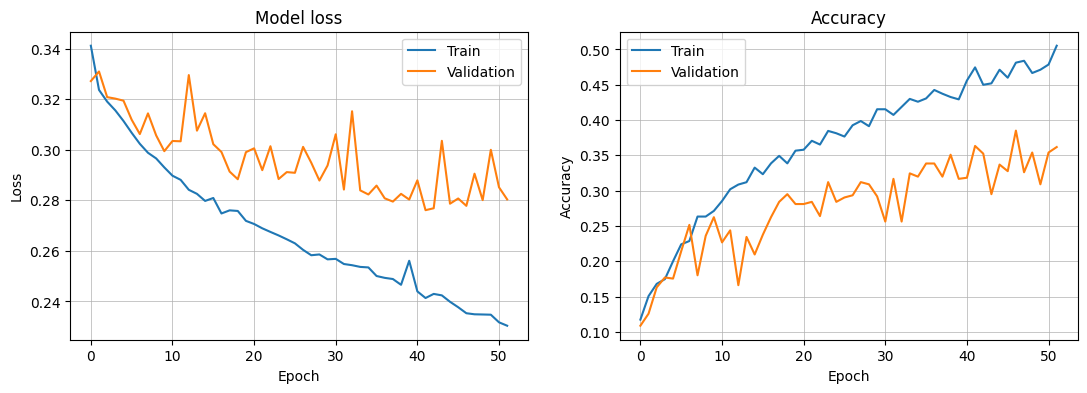

In [18]:
from utils import model_utils

model_utils.plot_history(history)

In [25]:
from utils import model_utils

model_utils.plot_history_interactive(history);

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Y Min:', max=1.0), FloatSli…